# Open-Loop Evaluation

In this notebook you are going to evaluate a CNN-based policy to control the SDV with a protocol named *open-loop* evaluation.

**Note: this notebook assumes you've already run the [training notebook](./train.ipynb) and stored your model successfully.**

## What is open-loop evaluation?
In open-loop evaluation we evaluate our model prediction as we follow the annotated ground truth.

In each frame, we compare the predictions of our model against the annotated ground truth. This can be done with different metrics, and we will see a few of them in the following.

**Regardless of the metric used, this evaluation protocol doesn't modify the future locations according to our predictions.**

![open-loop](../../docs/images/planning/open-loop.svg)


## What can we use open-loop evaluation for?
Open-loop evaluation can be used for a frame by frame comparison between the expert and the policy. This is extremely useful for debugging the model behaviours and investigate outlier predictions in specific situations (e.g. at crossings or unprotected turn).

## Is open-loop evaluation enough?
Regardless of the quality of the open-loop results, **this evaluation is not enough** to ensure your model will be able to actually drive on the road (that's where we all want to go in the end). If your model is not in full control of the SDV, you can't really say it will work once the annotated trajectory won't be available anymore.

Before drawing conclusions on our model we must test it when it is in full control of the SDV, in a setting called **closed-loop**. You can try just that in our [dedicated closed-loop evaluation notebook](./closed_loop_test.ipynb)

In [1]:
# test bayes library
from bayes_opt import BayesianOptimization

In [2]:
def black_box_function(x, y):
    """Function with unknown internals we wish to maximize.

    This is just serving as an example, for all intents and
    purposes think of the internals of this function, i.e.: the process
    which generates its output values, as unknown.
    """
    if (x > z):
        return -x ** 2 - (y - 1) ** 2 + 1
    return x ** 2 + (y - 1) ** 2 - 1

In [3]:
z = 20

# Bounded region of parameter space
pbounds = {'x': (2, 400), 'y': (-3, 300)}

optimizer = BayesianOptimization(
    f=black_box_function,
    pbounds=pbounds,
    verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=1,
)
optimizer.maximize(
    init_points=10,
    n_iter=100,
)
print(optimizer.max)

|   iter    |  target   |     x     |     y     |
-------------------------------------------------
|  1        | -7.412e+0 |  168.0    |  215.3    |
|  2        |  7.678e+0 |  2.046    |  88.61    |
|  3        | -4.223e+0 |  60.41    |  24.98    |
|  4        | -1.594e+0 |  76.13    |  101.7    |
|  5        | -5.094e+0 |  159.9    |  160.3    |
|  6        | -6.997e+0 |  168.8    |  204.6    |
|  7        | -7.563e+0 |  83.37    |  263.1    |
|  8        |  3.983e+0 |  12.9     |  200.2    |
|  9        | -5.557e+0 |  168.1    |  166.3    |
|  10       | -6.487e+0 |  57.87    |  57.02    |
|  11       |  2.672e+0 |  2.0      |  164.4    |
|  12       |  4.011e+0 |  11.68    |  200.9    |
|  13       | -1.6e+05  |  400.0    | -3.0      |
|  14       | -2.494e+0 |  400.0    |  300.0    |
|  15       |  19.0     |  2.0      | -3.0      |
|  16       | -3.59e+04 |  189.4    | -3.0      |
|  17       |  5.925e+0 |  2.0      |  244.4    |
|  18       |  8.94e+04 |  2.0      |  300.0    |


|  100      | -8.484e+0 |  276.4    |  92.82    |
|  101      | -2.994e+0 |  169.2    |  37.4     |
|  102      | -2.068e+0 |  21.28    |  143.2    |
|  103      | -7.609e+0 |  128.1    |  245.3    |
|  104      | -9.643e+0 |  48.74    |  86.25    |
|  105      | -1.96e+05 |  326.6    |  300.0    |
|  106      | -2.37e+04 |  153.9    | -3.0      |
|  107      | -3.651e+0 |  122.9    |  147.3    |
|  108      | -4.66e+04 |  199.4    |  83.74    |
|  109      |  8.433e+0 |  13.94    |  291.1    |
|  110      | -1.007e+0 |  107.8    |  299.4    |
{'target': 89710.79495079847, 'params': {'x': 17.629377493220503, 'y': 300.0}}


In [29]:
## from tempfile import gettempdir
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torch.utils.data.dataloader import default_collate
from tqdm import tqdm

from l5kit.configs import load_config_data
from l5kit.data import LocalDataManager, ChunkedDataset
from l5kit.dataset import AgentDataset
#from l5kit.dataset import EgoDataset
#from l5kit.rasterization import build_rasterizer
from l5kit.geometry import transform_points, angular_distance, transform_point
from l5kit.visualization import TARGET_POINTS_COLOR, PREDICTED_POINTS_COLOR, draw_trajectory
from l5kit.kinematic import AckermanPerturbation
from l5kit.random import GaussianRandomGenerator

from Param_Estimation.map.map_builder import MapBuilder
from Param_Estimation.driver.DRFModel import DRFModel
from Param_Estimation.map.rasterizer_builder import build_rasterizer
from Param_Estimation.dataset.ego import EgoDataset

import os

D:\YURUIDU\DRF_Simulation\Param_Estimation\venv\lib\site-packages\l5kit\dataset\select_agents.py:31: UserWarning: Windows detected. BLOSC_NOLOCK has not been set as it causes memory leaks on Windows.However, writing the mask with this config may be inconsistent.
  warnings.warn(
d:\yuruidu\drf_simulation\param_estimation\Param_Estimation\dataset\select_agents.py:31: UserWarning: Windows detected. BLOSC_NOLOCK has not been set as it causes memory leaks on Windows.However, writing the mask with this config may be inconsistent.
  warnings.warn(


## Prepare data path and load cfg

By setting the `L5KIT_DATA_FOLDER` variable, we can point the script to the folder where the data lies.

Then, we load our config file with relative paths and other configurations (rasteriser, training params...).

In [30]:
# set env variable for data
os.environ["L5KIT_DATA_FOLDER"] = "."
dm = LocalDataManager(None)
# get config
cfg = load_config_data("./config.yaml")

## Load the model

In [4]:
# model_path = "/tmp/planning_model.pt"
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# model = torch.load(model_path).to(device)
# model = model.eval()

## Load the evaluation data
This is almost the exact same code you've already seen in the [training notebook](./train.ipynb). Apart from the different dataset we load, the biggest difference is that **we don't perturb our data here**.

When performing evaluation we're interested in knowing the performance on the annotated data, not on perturbed one.

In [31]:
# ===== INIT DATASET
eval_cfg = cfg["val_data_loader"]
rasterizer = build_rasterizer(cfg, dm)
eval_zarr = ChunkedDataset(dm.require(eval_cfg["key"])).open()
eval_dataset = EgoDataset(cfg, eval_zarr, rasterizer)
eval_dataloader = DataLoader(eval_dataset, shuffle=eval_cfg["shuffle"], batch_size=eval_cfg["batch_size"], 
                             num_workers=eval_cfg["num_workers"])
print(eval_dataset)

+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
|    100     |   24838    |  1893736   |     316008    |       0.69      |        248.38        |        76.24         |        24.83         |        10.00        |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+


In [32]:
# driver controller here (from paper)
from typing import Dict, List, Optional, Tuple, Union
from scipy import optimize
from Param_Estimation.driver.DRFModel import DRFModel

#desired_vel = 15 # [m/s]
risk_threshold = 3000
k_h = 0.02 # gain of default heading P-controller
k_v = 0.14 # gain of vehicle's speed-up/down, could be different for normal or sport driving
k_vc = 1.5 * 1e-4 # gain of vehicle's speed-down contributed by the perceived risk (cost)
dt = 0.1 # [s] step time
dvMax = 4 * dt # [m/s^2] Vehicle max decel and acceleration
dsMax = np.pi / 180 * 10 * dt # [rad/dt] Note: Here assume steer limit is 10 degree/s, be careful with unit!
dstepMax = np.pi / 180 * 180 * dt # [rad/dt] Note: For fminbound search
egoDRF = DRFModel(p=0.0064, t_la=3.5, c=0.5, m=0.001, k_1=0, k_2=1.3823)

def driverController(curr_road_heading: float, ego_curr_heading_world: float, curr_risk: float, ego: DRFModel, v_des: float) -> Tuple[float, float]:
    desired_vel = v_des
    curr_vel = ego.v
    ego_heading = ego.phiv # assume ego's ground truth heading is the current road heading
    curr_steering = ego.delta
    next_steering =  curr_steering + k_h * (curr_road_heading - ego_curr_heading_world)
    if (curr_risk <= risk_threshold and curr_vel <= desired_vel):
        # condition 1
        # velocity update
        dv = np.fmin(dvMax, np.abs(k_v * (desired_vel - curr_vel)))
        next_vel = curr_vel + np.sign(desired_vel - curr_vel) * dv
        # steering update
        ds = np.fmin(np.abs(next_steering - curr_steering), dsMax)
        next_steering = curr_steering + np.sign(next_steering - curr_steering) * ds
        #print("condiion1 vel = ", next_vel)
        return next_steering, next_vel
    elif (curr_risk > risk_threshold and curr_vel <= desired_vel):
        # check if changing angular velocity can reduce the cost below the threshold
        opt_s, minCost, ierr, numfunc = optimize.fminbound(func=ego.optimizeSteering, x1=curr_steering - dstepMax, 
                                                                x2=curr_steering + dstepMax, full_output=True)
        if (minCost > risk_threshold):
            # condition 2a
            # steering angle update
            ds = np.fmin(np.abs(opt_s - curr_steering), dsMax)
            next_steering = curr_steering + np.sign(opt_s - curr_steering) * ds
            # velocity update
            dv = np.fmin(dvMax, np.abs(k_vc * (risk_threshold - minCost)))
            next_vel = curr_vel + np.sign(risk_threshold - minCost) * dv
            #print("condiion2a vel = ", next_vel)
            return next_steering, next_vel
            
#             model slows down
#             proportional to Cop − Ck (and not Cop − Ct) since the steering applied = wop is
#             expected to reduce Ck to Cop. This is done so that we do not slow down more than
#             what is required. Hence, w_k+1 = wop 
        elif (minCost <= risk_threshold):
            # condition 2b
            # velocity update
            dv = np.fmin(dvMax, np.abs(k_v * (desired_vel - curr_vel)))
            next_vel = curr_vel + np.sign(desired_vel - curr_vel) * dv
            # steering update
            next_steering = curr_steering + k_h * (curr_road_heading - ego_heading)
            opt_s, minCost, ierr, numfunc = optimize.fminbound(func=ego.optimizeSteeringCt, x1=curr_steering - dstepMax, 
                                                            x2=curr_steering + dstepMax, full_output=True)

            ds = np.fmin(np.abs(opt_s - curr_steering), dsMax)
            next_steering = curr_steering + np.sign(opt_s - curr_steering) * ds
            #print("condiion2b vel = ", next_vel)
            return next_steering, next_vel

        else:
            print("Error in stage: condition 2")
        
        # /* In this case the model slows down, while being
        # ** steered by the heading controller since the risk is lower than the threshold and
        # ** speed is higher than what is desired.
        # */
    elif (curr_risk <= risk_threshold and curr_vel > desired_vel):
        # condition 3
        # steering update
        ds = np.fmin(np.abs(next_steering - curr_steering), dsMax)
        next_steering = curr_steering + np.sign(next_steering - curr_steering) * ds
        # velocity update
        dv = np.fmin(dvMax, np.abs(k_v * (desired_vel - curr_vel)))
        next_vel = curr_vel + np.sign(desired_vel - curr_vel) * dv
        #print("condiion3 vel = ", next_vel)
        return next_steering, next_vel
        
        # /* In this case both the speed and risk are over
        # ** the desired limits and hence the model slows down while steering with δop that
        # ** minimises Ck
        # */
    elif (curr_risk > risk_threshold and curr_vel > desired_vel):
        # condition 4
        # velocity update
        dv = np.fmin(dvMax, np.abs(k_v * (desired_vel - curr_vel)))
        next_vel = curr_vel + np.sign(desired_vel - curr_vel) * dv
        # steering update
        opt_s, minCost, ierr, numfunc = optimize.fminbound(func=ego.optimizeSteeringCt, x1=curr_steering - dstepMax, 
                                                            x2=curr_steering + dstepMax, full_output=True)

        ds = np.fmin(np.abs(opt_s - curr_steering), dsMax)
        next_steering = curr_steering + np.sign(opt_s - curr_steering) * ds
        #print("condiion4 vel = ", next_vel)
        return next_steering, next_vel

    else: 
        print("Error at driver controller: no situations match!")
    print("Next steering = ", next_steering)
    print("Next Velocity = ", next_vel)

In [6]:
# ===== Parameter Estimation (open-loop)

""" Pseudo code
for each scene:
    from the first frame:
        read x_0, y_0, phi_0
        assume delta_0 = 0
        by frame1 - frame 0, get v_0
    for each frame:
        obj_map -> DRF -> next x, y, phi, delta, v
        record x, y
        record ground truth

Compare gt to actual
"""
position_preds = []
yaw_preds = []
position_preds_world = []
yaw_preds_world = []

position_gts = []
yaw_gts = []
position_gts_world = []
yaw_gts_world = []

dataset = eval_dataset

# number of scenes depends on the size of the dataset, here we use sample.zarr
for scene_idx in range(100): 
    indexes = dataset.get_scene_indices(scene_idx)
    obj_map = []
    
    # Initialisation
    first_frame_idx = indexes[0]
    first_frame = dataset[first_frame_idx]

    ego_curr_heading_world = first_frame["yaw"]
    
    for idx in indexes:
        # Note: Accessing pose from Egodataset seems to have agent(ego-as-agent) coordinates
        curr_frame = dataset[idx]
        #next_frame = dataset[idx + 1]
#         egoDRF.x = curr_frame["history_positions"][-1:][0] # or first_frame["centroid"][:2]? (world frame)
#         egoDRF.y = curr_frame["history_positions"][-1:][1] # Both should be converted to raster frame
        pos_in_rast = np.reshape(transform_points(curr_frame["history_positions"][-1:], curr_frame["raster_from_agent"]), 2)
        
        egoDRF.x = pos_in_rast[0]
        #print(egoDRF.x)
        egoDRF.y = pos_in_rast[1]
#         print(curr_frame["yaw"]) 0.9912326975497529
#         print(curr_frame["history_yaws"][-1:]) [[0.]]
        egoDRF.phiv = curr_frame["history_yaws"][-1:] # curr_frame["history_yaws"][-1:] or first_frame["yaw"]? (world frame) not sure if same as in raster
        #print(egoDRF.phiv)
        # TODO: Assume at the start of each scene, the vehicle's heading is the road heading
        # Need to implement a method to compute the road heading of the ego vehicle as the road heading can change through the scene
        curr_road_heading = curr_frame["yaw"] 

        # initial ego velocity is the last one from history velocities (raster frame)
        #egoDRF.v = np.sqrt(np.sum(np.square(curr_frame["history_velocities"][-1:]))) # this doesn't work as all elements are zeros
        
        next_pos_in_rast = np.reshape(transform_point(curr_frame["target_positions"][0], curr_frame["raster_from_agent"]), 2)
        diff_pos_in_rast = next_pos_in_rast - pos_in_rast
        egoDRF.v = np.sqrt(np.sum(np.square(diff_pos_in_rast)))
        #print(curr_frame["history_velocities"][-1:])
        egoDRF.obj_map = curr_frame["image"]
        
        p_risk = egoDRF.overallProcess()
        egoDRF.delta, egoDRF.v = driverController(curr_road_heading, ego_curr_heading_world, p_risk, egoDRF)
        #print(egoDRF.phiv)
        egoDRF.carKinematics()
        ego_curr_heading_world += egoDRF.phiv
        
        # Record groundtruth path
        position_gts.append(curr_frame["target_positions"][0])
        yaw_gts.append(curr_frame["target_yaws"][0])
        ego_gt_pos_world = transform_point(curr_frame["target_positions"][0], curr_frame["world_from_agent"])
        position_gts_world.append(ego_gt_pos_world) # curr_frame["centroid"]
        # Record actual path
        # All driver controller computation is done in the raster frame, change prediction to agent frame for evaluation
        ego_pred_in_agent = transform_point(np.reshape(np.array([egoDRF.x, egoDRF.y]), 2), np.linalg.inv(curr_frame["raster_from_agent"]))
        ego_pred_in_world = transform_point(np.reshape(np.array([egoDRF.x, egoDRF.y]), 2), np.linalg.inv(curr_frame["raster_from_world"]))
        position_preds.append(ego_pred_in_agent)
        position_preds_world.append(ego_pred_in_world)
        yaw_preds.append(egoDRF.phiv)
    break
#print(yaw_gts)


[[ 0.48548393  0.78248125]
 [ 0.49855205  0.77670044]
 [ 0.49617523  0.7757541 ]
 [ 0.49781469  0.77148074]
 [ 0.51951716  0.77511365]
 [ 0.51146199  0.77813693]
 [ 0.50284621  0.77753781]
 [ 0.53774226  0.76553341]
 [ 0.53312817  0.77269108]
 [ 0.53473876  0.78840023]
 [ 0.56210124  0.762212  ]
 [ 0.54338278  0.80263831]
 [ 0.54794932  0.82453928]
 [ 0.57650641  0.81292346]
 [ 0.54266418  0.84606598]
 [ 0.56973004  0.83747651]
 [ 0.58746527  0.83946978]
 [ 0.56909691  0.8820945 ]
 [ 0.57389341  0.88772295]
 [ 0.59602423  0.88231289]
 [ 0.57793744  0.86837157]
 [ 0.59237098  0.90225491]
 [ 0.60498353  0.90183008]
 [ 0.59113677  0.90860257]
 [ 0.60505893  0.90745631]
 [ 0.62477583  0.91125586]
 [ 0.61976196  0.91944156]
 [ 0.6374953   0.91015136]
 [ 0.63920164  0.91432571]
 [ 0.637923    0.92046098]
 [ 0.63394692  0.92784735]
 [ 0.63225313  0.93626972]
 [ 0.64012133  0.92522202]
 [ 0.61930162  0.93710536]
 [ 0.62435912  0.94856359]
 [ 0.62425528  0.94189561]
 [ 0.62779458  0.94166046]
 

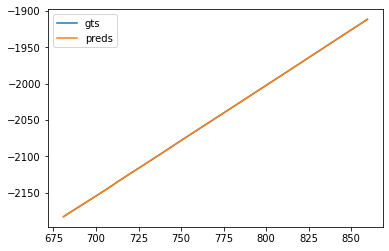

In [15]:
arr1 = np.array(position_gts_world)
arr2 = np.array(position_preds_world)
arr = arr1 - arr2
print(arr)
plt.plot(arr1[:, 0], arr1[:, 1], label = "gts")
plt.plot(arr2[:, 0], arr2[:, 1], label = "preds")
plt.legend()
plt.show()
#plt.scatter(arr[:, 0], arr[:, 1], marker='.')
#axes = plt.gca()

In [5]:
# Compute the error in position between gt and pred
def computePosError(preds: np.ndarray, gts: np.ndarray) -> Tuple[np.ndarray, float]:
    error_arr = np.array(gts) - np.array(preds)
    error_x = error_arr[:, 0]
    error_y = error_arr[:, 1]
    error_pos = np.sqrt(error_x**2 + error_y**2)
    mean_error_pos = np.mean(error_pos)
    return error_pos, mean_error_pos

def computeYawError(preds: np.ndarray, gts: np.ndarray) -> Tuple[np.ndarray, float]:
    yaw_preds = np.ravel(np.array(preds))
    yaw_gts = np.ravel(np.array(gts))
#     print(yaw_preds)
#     print(yaw_gts)
    error_yaws = yaw_gts - yaw_preds
    mean_error_yaw = np.mean(error_yaws)
    return error_yaws, mean_error_yaw

In [12]:
def optimize_black_box(p, t_la, m, k_1, k_2) -> float:
    egoDRF.p = p
    egoDRF.t_la = t_la
    egoDRF.m = m
    egoDRF.k_1 = k_1
    egoDRF.k_2 = k_2
    
    position_preds = []
    yaw_preds = []
    position_preds_world = []
    yaw_preds_world = []
    vel_preds = []

    position_gts = []
    yaw_gts = []
    position_gts_world = []
    yaw_gts_world = []
    #print(indexes)
    for idx in indexes[:50]: # First 5s in each scene
        # Note: Accessing pose from Egodataset seems to have agent(ego-as-agent) coordinates
        curr_frame = dataset[idx]
        curr_road_heading = curr_frame["yaw"] 

        #ego_yaw_world =  yaw_diff_world_agent # in raster frame, ego heading is always 0
        #ego_yaw_world = np.reshape(ego_yaw_world, 1)
        #print(ego_yaw_world[0])
        global ego_position_world
        global ego_curr_heading_world
        if (idx == indexes[0]):
            ego_position_world = f_ego_position_world
            ego_curr_heading_world = f_ego_curr_heading_world # here yaw_world
            egoDRF.v = f_vel
        
        egoDRF.obj_map = dataset.get_image_from_position(frame_idx=idx, position=ego_position_world, yaw=ego_curr_heading_world)
        egoDRF.x = 25 # or first_frame["centroid"][:2]? (world frame)
        egoDRF.y = 25
        egoDRF.phiv = 0. # here yaw_rast
        
        p_risk = egoDRF.overallProcess()
        egoDRF.delta, egoDRF.v = driverController(curr_road_heading, ego_curr_heading_world, p_risk, egoDRF, f_vel)
        egoDRF.carKinematics()
        ego_curr_heading_world += egoDRF.phiv #
        
        # Record groundtruth path
        position_gts.append(curr_frame["target_positions"][0])
        yaw_gts.append(curr_frame["target_yaws"][0])
        ego_gt_pos_world = curr_frame["centroid"] # transform_point(curr_frame["target_positions"][0], curr_frame["world_from_agent"])
#         print(curr_frame["centroid"])
#         print(ego_gt_pos_world)
        position_gts_world.append(ego_gt_pos_world)
        # Record actual path
        # All driver controller computation is done in the raster frame, change prediction to agent frame for evaluation
        pose_in_world = np.array(
            [
                [np.cos(ego_curr_heading_world), -np.sin(ego_curr_heading_world), ego_position_world[0]],
                [np.sin(ego_curr_heading_world), np.cos(ego_curr_heading_world), ego_position_world[1]],
                [0, 0, 1],
            ]
        )
        
        raster_from_world = dataset.rasterizer.render_context.raster_from_local @ np.linalg.inv(pose_in_world)
        ego_position_world = transform_point(np.reshape(np.array([egoDRF.x, egoDRF.y]), 2), np.linalg.inv(raster_from_world))
        
        #ego_pred_in_agent = transform_point(np.reshape(np.array([egoDRF.x, egoDRF.y]), 2), np.linalg.inv(curr_frame["raster_from_agent"]))
        #ego_pred_in_world = transform_point(np.reshape(np.array([egoDRF.x, egoDRF.y]), 2), np.linalg.inv(curr_frame["raster_from_world"]))
        #position_preds.append(ego_pred_in_agent)
        position_preds_world.append(ego_position_world)
        yaw_preds.append(egoDRF.phiv)
        yaw_preds_world.append(ego_curr_heading_world)
        vel_preds.append(egoDRF.v)
        
    #print(np.array(position_preds_world).shape)    
    error_arr, mean_error_pos = computePosError(position_preds_world, position_gts_world)
    #print(error_arr)
    return 1 / mean_error_pos
    
    

In [13]:
# ===== Parameter Estimation (closed-loop)

""" Pseudo code
for each scene:
    from the first frame:
        read x_0, y_0, phi_0
        assume delta_0 = 0
        by frame1 - frame 0, get v_0
    for each frame:
        obj_map -> DRF -> next x, y, phi, delta, v
        record x, y
        record ground truth

Compare gt to actual
"""

position_preds = []
yaw_preds = []
position_preds_world = []
yaw_preds_world = []
vel_preds = []

position_gts = []
yaw_gts = []
position_gts_world = []
yaw_gts_world = []
vel_gts = []
best_params = []

dataset = eval_dataset

# number of scenes depends on the size of the dataset, here we use sample.zarr
for scene_idx in range(100): 
    indexes = dataset.get_scene_indices(scene_idx)
    obj_map = []
    
    # Initialisation
    # Note: Accessing pose from Egodataset seems to have agent(ego-as-agent) coordinates
    first_frame_idx = indexes[0]
    first_frame = dataset[first_frame_idx]
    first_pos_rast = np.reshape(transform_points(first_frame["history_positions"][-1:], first_frame["raster_from_agent"]), 2)
    #print(first_pos_rast)
    #|  101      |  0.1319   |  0.2968   |  1.362    |  0.08453  |  0.9642   |  3.282    |  8.203    |
    egoDRF = DRFModel(p=0.0064, t_la=3.5, c=0.5, m=0.001, k_1=0., k_2=1.3823)
    #v_des = 15 
    # egoDRF in raster frame
    egoDRF.x = first_pos_rast[0] # or first_frame["centroid"][:2]? (world frame)
    egoDRF.y = first_pos_rast[1]
    
    # world frame initial pose of ego vehicle
    x0 = first_frame["centroid"][0]
    y0 = first_frame["centroid"][1]
    phiv0 = first_frame["yaw"] # or first_frame["yaw"]? (world frame)
    #print(first_frame["history_yaws"][-1:])
    f_ego_curr_heading_world = first_frame["yaw"] #- first_frame["history_yaws"][-1:]
    f_ego_position_world = transform_point(np.reshape(np.array([egoDRF.x, egoDRF.y]), 2), np.linalg.inv(first_frame["raster_from_world"]))
    #print(yaw_diff_world_agent)
    
    # compute gt velocity
    for idx in indexes[:50]: # First 5s in each scene
        # Note: Accessing pose from Egodataset seems to have agent(ego-as-agent) coordinates
        curr_frame = dataset[idx]
        curr_road_heading = curr_frame["yaw"]
        next_frame = dataset[idx + 1]
        
        # compute gt velocity
        x_curr = curr_frame["centroid"][0]
        y_curr = curr_frame["centroid"][1]
        x_next = next_frame["centroid"][0]
        y_next = next_frame["centroid"][1]
        
        diff_pos_in_world = np.sqrt((x_next - x_curr)**2 + (y_next - y_curr)**2)
        gt_vel = diff_pos_in_world / 0.1 # dt = 0.1s
        vel_gts.append(gt_vel)
    f_vel = np.mean(np.array(vel_gts))
    egoDRF.v = f_vel
    
    # Bounded region of parameter space
    pbounds = {'p': (0, 1), 't_la': (2, 4), 'm': (0, 0.1), 'k_1': (0, 1), 'k_2': (1, 2)}

    optimizer = BayesianOptimization(
        f=optimize_black_box,
        pbounds=pbounds,
        verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
        random_state=1,
    )
    optimizer.probe(
    params={'p': 0.0064, 't_la': 3.5, 'm': 0.001, 'k_1': 0, 'k_2': 1.3823},
    lazy=False,
    )
    optimizer.maximize(
        init_points=10,
        n_iter=200,
    )
    print(optimizer.max)
    best_params.append(optimizer.max)
    vel_gts = []
    
    if (scene_idx == 0):
        break
    

|   iter    |  target   |    k_1    |    k_2    |     m     |     p     |   t_la    |
-------------------------------------------------------------------------------------
|  1        |  0.387    |  0.417    |  1.72     |  1.144e-0 |  0.3023   |  2.294    |
|  2        |  0.2589   |  0.09234  |  1.186    |  0.03456  |  0.3968   |  3.078    |
|  3        |  0.3881   |  0.4192   |  1.685    |  0.02045  |  0.8781   |  2.055    |
|  4        |  0.3839   |  0.6705   |  1.417    |  0.05587  |  0.1404   |  2.396    |
|  5        |  0.4456   |  0.8007   |  1.968    |  0.03134  |  0.6923   |  3.753    |
|  6        |  0.3883   |  0.8946   |  1.085    |  0.003905 |  0.1698   |  3.756    |
|  7        |  0.1649   |  0.09835  |  1.421    |  0.09579  |  0.5332   |  3.384    |
|  8        |  0.2486   |  0.3155   |  1.687    |  0.08346  |  0.01829  |  3.5      |
|  9        |  0.03453  |  0.9889   |  1.748    |  0.02804  |  0.7893   |  2.206    |
|  10       |  0.03418  |  0.4479   |  1.909    |  0.0

|  58       |  0.03462  |  0.9632   |  1.755    |  0.04059  |  0.2442   |  2.28     |
|  59       |  0.03458  |  0.6039   |  1.634    |  0.08683  |  0.5483   |  3.088    |
|  60       |  0.03457  |  0.9262   |  1.197    |  0.04634  |  0.5223   |  2.522    |
|  61       |  0.0346   |  0.2132   |  1.978    |  0.07611  |  0.1564   |  2.018    |
|  62       |  0.03468  |  0.5      |  1.491    |  0.04436  |  0.4656   |  2.809    |
|  63       |  0.03454  |  0.8208   |  1.207    |  0.08118  |  0.6917   |  2.602    |
|  64       |  0.03458  |  0.3642   |  1.284    |  0.08024  |  0.6264   |  2.779    |
|  65       |  0.03458  |  0.5392   |  1.915    |  0.04347  |  0.6171   |  3.938    |
|  66       |  0.0347   |  0.2361   |  1.814    |  0.05745  |  0.7892   |  2.14     |
|  67       |  0.03461  |  0.1124   |  1.238    |  0.00371  |  0.8613   |  3.053    |
|  68       |  0.03469  |  0.9201   |  1.631    |  0.08205  |  0.9239   |  2.669    |
|  69       |  0.03453  |  0.1274   |  1.088    |  0.0

|  116      |  0.03462  |  0.1427   |  1.174    |  0.04233  |  0.5012   |  3.897    |
|  117      |  0.03453  |  0.6657   |  1.957    |  0.0179   |  0.9479   |  2.853    |
|  118      |  0.03425  |  0.1897   |  1.097    |  0.07047  |  0.2489   |  2.436    |
|  119      |  0.03467  |  0.7688   |  1.518    |  0.0738   |  0.8886   |  3.986    |
|  120      |  0.03454  |  0.2815   |  1.2      |  0.06     |  0.6521   |  2.67     |
|  121      |  0.03452  |  0.9058   |  1.058    |  0.0296   |  0.1943   |  2.24     |
|  122      |  0.03467  |  0.6055   |  1.257    |  0.04057  |  0.253    |  2.827    |
|  123      |  0.03465  |  0.1669   |  1.207    |  0.05332  |  0.9775   |  3.961    |
|  124      |  0.03455  |  0.8204   |  1.851    |  0.0851   |  0.5016   |  3.91     |
|  125      |  0.03458  |  0.4903   |  1.734    |  0.08173  |  0.1311   |  2.147    |
|  126      |  0.03459  |  0.4616   |  1.273    |  0.014    |  0.4757   |  3.614    |
|  127      |  0.03459  |  0.6945   |  1.027    |  0.0

|  174      |  0.03428  |  0.5854   |  1.963    |  0.09056  |  0.2691   |  3.679    |
|  175      |  0.03466  |  0.9673   |  1.419    |  0.09255  |  0.1595   |  2.876    |
|  176      |  0.03453  |  0.6777   |  1.163    |  0.03459  |  0.1468   |  2.894    |
|  177      |  0.0346   |  0.2928   |  1.353    |  0.08065  |  0.2044   |  2.931    |
|  178      |  0.03462  |  0.996    |  1.301    |  0.005462 |  0.3248   |  3.726    |
|  179      |  0.03462  |  0.6995   |  1.267    |  0.09318  |  0.1826   |  3.781    |
|  180      |  0.03456  |  0.803    |  1.143    |  0.02374  |  0.9037   |  3.189    |
|  181      |  0.03467  |  0.1405   |  1.817    |  0.08441  |  0.3435   |  2.411    |
|  182      |  0.03459  |  0.8602   |  1.723    |  0.04798  |  0.3796   |  2.641    |
|  183      |  0.03451  |  0.1325   |  1.337    |  0.007804 |  0.3339   |  2.446    |
|  184      |  0.03461  |  0.5163   |  1.643    |  0.01753  |  0.5003   |  2.166    |
|  185      |  0.03466  |  0.8858   |  1.355    |  0.0

In [38]:
#print(best_params)
np.savetxt("GFG.csv", 
           best_params,
           delimiter =", ", 
           fmt ='% s')

In [39]:
# save process
from bayes_opt.logger import JSONLogger
from bayes_opt.event import Events

logger = JSONLogger(path="./logs.json")
optimizer.subscribe(Events.OPTIMIZATION_STEP, logger)


In [42]:
# load process (example)
from bayes_opt.util import load_logs

# Bounded region of parameter space
pbounds = {'p': (0, 1), 't_la': (2, 4), 'm': (0, 0.1), 'k_1': (0, 1), 'k_2': (1, 2), 'v_des': (0, 20)}

new_optimizer = BayesianOptimization(
    f=optimize_black_box,
    pbounds=pbounds,
    verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=1,
)
new_optimizer.probe(
params={'p': 0.0064, 't_la': 3.5, 'm': 0.001, 'k_1': 0, 'k_2': 1.3823},
lazy=False,
)

print(len(new_optimizer.space))

load_logs(new_optimizer, logs=["./logs.json"])
print("New optimizer is now aware of {} points.".format(len(new_optimizer.space)))

new_optimizer.maximize(
    init_points=0,
    n_iter=10,
)



1


FileNotFoundError: [Errno 2] No such file or directory: './logs.json'

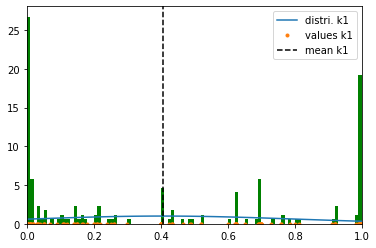

In [28]:
# visualise parameters' distribution

# read from all .csv files in the ".\results" folder
import glob
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from scipy.stats import norm

directory_path = os.path.dirname(os.getcwd()+'\\results\\')
#print(glob.glob(directory_path+'*.csv'))

# for file_name in glob.glob(directory_path + '*.csv'):

#     x = pd.read_csv(file_name)
#     glued_data = pd.contat([glued_data, x],axis=0)
#     #k_1 = np.genfromtxt(file_name, delimiter=',')[:, 0]
#     print(glued_data)

k_1 = []
for root,dirs,files in os.walk(directory_path):
    for file in files:
        if (file.endswith(".csv")):
            x = pd.read_csv(os.path.join(directory_path , file))
            x = x[x['       performance'] >= x['       performance'][0]] # select designs at least as good as the baseline
            k_1 = np.concatenate((np.asarray(k_1), x['           k_1_in'])) 
            
            #glued_data = pd.concat([glued_data, x],axis=0)
            #print(glued_data)
            
mean = np.mean(k_1)
std = np.std(k_1)
x_k1 = np.linspace(mean - 3 * std, mean + 3 * std, 100)
plt.plot(x_k1, stats.norm.pdf(x_k1, mean, std), label='distri. k1')

plt.plot(k_1, np.zeros(k_1.shape), marker= '.', linestyle='None', label='values k1')
plt.axvline(mean, color='k', linestyle='dashed', label='mean k1')

# mu, sigma = norm.fit(k_1)
# print(sigma)
# print(mu)
# plot histogram (y-axis is the probability density)
n, bins, patches = plt.hist(k_1, bins=100, density=True, color='g', stacked=True)
# print(n)
# print(bins)
# print(patches)

axes = plt.gca()
axes.set_xlim([0, 1])
#axes.set_ylim([0, 1])
axes.legend()

In [36]:
# Select lane-keeping scenes
valid_scene_indices = []
vels = []
yaws = []
dataset = eval_dataset

for scene_idx in range(100): 
    indexes = dataset.get_scene_indices(scene_idx)
    for idx in indexes[:-1]: # throughout each scene
        # Note: Accessing pose from Egodataset seems to have agent(ego-as-agent) coordinates
        curr_frame = dataset[idx]
        curr_road_heading = curr_frame["yaw"]
        next_frame = dataset[idx + 1]
        yaws.append(curr_road_heading)
        
        # compute gt velocity
        x_curr = curr_frame["centroid"][0]
        y_curr = curr_frame["centroid"][1]
        x_next = next_frame["centroid"][0]
        y_next = next_frame["centroid"][1]
        
        diff_pos_in_world = np.sqrt((x_next - x_curr)**2 + (y_next - y_curr)**2)
        gt_vel = diff_pos_in_world / 0.1 # dt = 0.1s
        vels.append(gt_vel)
    
    vels = np.array(vels)
    yaws = np.array(yaws)
    if (np.mean(vels) > 2.0 and np.max(np.abs(np.diff(yaws))) < 10 / 180 * np.pi):
        valid_scene_indices.append(scene_idx)
    vels = []
    yaws = []

In [46]:
# see valid lane keeping scenes
valid_scene_indices = np.array(valid_scene_indices)
print(valid_scene_indices)
# for scene_idx in valid_scene_indices:
#     print(scene_idx)
# indices = [0, 1] 
# print(indices)

[ 0  1  6  7  8  9 10 11 13 14 15 16 18 19 20 21 22 23 25 28 29 30 31 34
 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 55 56 57 58 59 62
 63 64 65 66 69 70 71 72 73 74 75 76 77 78 80 81 82 83 84 85 89 90 91 93
 94 95 96 97 98 99]
[0, 1]


In [227]:
# ===== Parameter Estimation (closed-loop)

""" Pseudo code
for each scene:
    from the first frame:
        read x_0, y_0, phi_0
        assume delta_0 = 0
        by frame1 - frame 0, get v_0
    for each frame:
        obj_map -> DRF -> next x, y, phi, delta, v
        record x, y
        record ground truth

Compare gt to actual
"""

position_preds = []
yaw_preds = []
position_preds_world = []
yaw_preds_world = []
vel_preds = []

position_gts = []
yaw_gts = []
position_gts_world = []
yaw_gts_world = []
vel_gts = []

dataset = eval_dataset

# number of scenes depends on the size of the dataset, here we use sample.zarr
for scene_idx in range(100): 
    indexes = dataset.get_scene_indices(6)
    obj_map = []
    
    # Initialisation
    # Note: Accessing pose from Egodataset seems to have agent(ego-as-agent) coordinates
    first_frame_idx = indexes[0]
    first_frame = dataset[first_frame_idx]
    first_pos_rast = np.reshape(transform_points(first_frame["history_positions"][-1:], first_frame["raster_from_agent"]), 2)
    #print(first_pos_rast)
    #{'k_1': 0.8007445686755367, 'k_2': 1.9682615757193975, 'm': 0.031342417815924284, 'p': 0.6923226156693141, 't_la': 3.7527783045920766}}
    #params={'p': 0.0064, 't_la': 3.5, 'm': 0.001, 'k_1': 0, 'k_2': 1.3823}
    #egoDRF = DRFModel(p=0.1432, t_la=2.97, c=0.5, m=0.06944, k_1=0.4677, k_2=1.556)
    egoDRF = DRFModel(p=0.986, t_la=1, c=0.5, m=0., k_1=0.237, k_2=1.881)
    #v_des = 15 
    # egoDRF in raster frame
    egoDRF.x = first_pos_rast[0] # or first_frame["centroid"][:2]? (world frame)
    egoDRF.y = first_pos_rast[1]
    
    # world frame initial pose of ego vehicle
    x0 = first_frame["centroid"][0]
    y0 = first_frame["centroid"][1]
    phiv0 = first_frame["yaw"] # or first_frame["yaw"]? (world frame)
    #print(first_frame["history_yaws"][-1:])
    ego_curr_heading_world = first_frame["yaw"] #- first_frame["history_yaws"][-1:]
    ego_position_world = transform_point(np.reshape(np.array([egoDRF.x, egoDRF.y]), 2), np.linalg.inv(first_frame["raster_from_world"]))
    #print(yaw_diff_world_agent)
    
    # TODO: Assume at the start of each scene, the vehicle's heading is the road heading
    # Need to implement a method to compute the road heading of the ego vehicle as the road heading can change through the scene
    #curr_road_heading = first_frame["history_yaws"][-1:] # in raster frame
    sec_frame_idx = indexes[1]
    sec_frame = dataset[sec_frame_idx]
    
    # initial ego velocity is computed from the ground truth position
#     egoDRF.v = np.sqrt(((sec_frame["history_positions"][-1:][0] - egoDRF.x) / dt)**2 + 
#                 ((sec_frame["history_positions"][-1:][1] - egoDRF.y) / dt)**2)
    sec_pos_in_rast = np.reshape(transform_point(first_frame["target_positions"][0], first_frame["raster_from_agent"]), 2)
    diff_pos_in_rast = sec_pos_in_rast - first_pos_rast
#     first_vel = np.sqrt(np.sum(np.square(diff_pos_in_rast))) / 0.1 # dt = 0.1
#     egoDRF.v = first_vel
    #print(first_vel)
    # compute gt velocity
    for idx in indexes[:50]: # First 5s in each scene
        # Note: Accessing pose from Egodataset seems to have agent(ego-as-agent) coordinates
        curr_frame = dataset[idx]
        curr_road_heading = curr_frame["yaw"]
        next_frame = dataset[idx + 1]
        
        # compute gt velocity
        x_curr = curr_frame["centroid"][0]
        y_curr = curr_frame["centroid"][1]
        x_next = next_frame["centroid"][0]
        y_next = next_frame["centroid"][1]
        
        diff_pos_in_world = np.sqrt((x_next - x_curr)**2 + (y_next - y_curr)**2)
        gt_vel = diff_pos_in_world / 0.1 # dt = 0.1s
        tmp_gt_vel = []
        tmp_gt_vel.append(gt_vel)
        vel_gts.append(gt_vel)
    #vel_gts = np.array(vel_gts)
    f_vel = np.mean(np.array(tmp_gt_vel))
    egoDRF.v = f_vel
    
    for idx in indexes[:50]: # First 5s in each scene
        # Note: Accessing pose from Egodataset seems to have agent(ego-as-agent) coordinates
        curr_frame = dataset[idx]
        curr_road_heading = curr_frame["yaw"]
        next_frame = dataset[idx + 1]
        
        egoDRF.obj_map = dataset.get_image_from_position(frame_idx=idx, position=ego_position_world, yaw=ego_curr_heading_world)
        
#         # for debugging
#         plt.imshow(egoDRF.obj_map)
#         plt.show()
#         # for debugging
        
        egoDRF.x = 25 # or first_frame["centroid"][:2]? (world frame)
        egoDRF.y = 25
        egoDRF.phiv = 0.
        
        p_risk = egoDRF.overallProcess()
        egoDRF.delta, egoDRF.v = driverController(curr_road_heading, ego_curr_heading_world, p_risk, egoDRF, f_vel)
        egoDRF.carKinematics()
        ego_curr_heading_world += egoDRF.phiv
        
        # Record groundtruth path
        position_gts.append(curr_frame["target_positions"][0])
        yaw_gts.append(curr_frame["target_yaws"][0])
        yaw_gts_world.append(curr_frame["yaw"])
        ego_gt_pos_world = curr_frame["centroid"]#transform_point(curr_frame["target_positions"][0], curr_frame["world_from_agent"])
        position_gts_world.append(ego_gt_pos_world) # 
        # Record actual path
        # All driver controller computation is done in the raster frame, change prediction to agent frame for evaluation
        pose_in_world = np.array(
            [
                [np.cos(ego_curr_heading_world), -np.sin(ego_curr_heading_world), ego_position_world[0]],
                [np.sin(ego_curr_heading_world), np.cos(ego_curr_heading_world), ego_position_world[1]],
                [0, 0, 1],
            ]
        )
        
        raster_from_world = dataset.rasterizer.render_context.raster_from_local @ np.linalg.inv(pose_in_world)
        ego_position_world = transform_point(np.reshape(np.array([egoDRF.x, egoDRF.y]), 2), np.linalg.inv(raster_from_world))
        
        #ego_pred_in_agent = transform_point(np.reshape(np.array([egoDRF.x, egoDRF.y]), 2), np.linalg.inv(curr_frame["raster_from_agent"]))
        #ego_pred_in_world = transform_point(np.reshape(np.array([egoDRF.x, egoDRF.y]), 2), np.linalg.inv(curr_frame["raster_from_world"]))
        #position_preds.append(ego_pred_in_agent)
        position_preds_world.append(ego_position_world)
        yaw_preds.append(egoDRF.phiv)
        yaw_preds_world.append(ego_curr_heading_world)
        
        vel_preds.append(egoDRF.v)
#     if (scene_idx == 10):
#         break
    break
#print(yaw_gts)

In [228]:
arr1 = np.array(vel_gts)
arr2 = np.array(vel_preds)
arr = arr1 - arr2
print(arr)

[-6.49613914 -5.865781   -5.71340375 -5.64455882 -6.05215665 -5.40113925
 -5.27835139 -4.6872673  -4.21686258 -3.51901789 -2.85266638 -2.27032607
 -1.73546205 -1.05175086 -1.24592669 -1.42011285 -1.73797132 -1.86856598
 -1.8880561  -1.35640769 -0.86303202 -0.34149171 -0.52886734  0.02362403
  0.57527784  1.056299    1.22762807  1.84657219  1.50773368  1.85605062
  2.39834109  2.14161087  1.8892164   2.47676331  2.98753293  2.57644825
  3.13809717  3.62242205  4.1045075   3.80328746  4.25361695  4.77107419
  4.45538128  4.87652142  4.94344007  4.83932554  5.37762403  4.99450953
  5.47632792  5.70150623]


In [229]:
#error_arr, mean_error_yaw = computeYawError(yaw_preds_world, yaw_gts)
error_arr, mean_error_pos = computePosError(position_preds_world, position_gts_world)
print(np.std(error_arr))
print(mean_error_pos)
print(error_arr)
np.savetxt("mean_error.csv", 
           error_arr,
           delimiter =", ", 
           fmt ='% f')

2.0755174326304604
6.9866201535824555
[0.76962128 1.37932884 1.97713633 2.55782433 3.12967586 3.74061469
 4.28433054 4.7676618  5.19022714 5.56633048 5.87248382 6.11383204
 6.29998635 6.43835503 6.59402488 6.77182783 6.96985248 7.21021088
 7.45938145 7.65726937 7.80803598 7.91943322 8.06845798 8.16439916
 8.21320874 8.21765162 8.22134737 8.1949942  8.19821196 8.18578324
 8.1364603  8.14438287 8.18711308 8.18742841 8.15615363 8.17247436
 8.18141871 8.12861516 8.10205167 8.11101708 8.12547663 8.14296456
 8.21202633 8.29080824 8.38507718 8.55492275 8.70887599 8.9133996
 9.14547629 9.40336592]


PermissionError: [Errno 13] Permission denied: 'mean_error.csv'

In [205]:
error_arr, mean_error_yaw = computeYawError(yaw_preds_world, yaw_gts_world)
print(error_arr)
print(mean_error_yaw)

[-6.65381750e-09 -3.90473666e-04 -1.39091266e-03 -2.77477599e-03
 -4.38662670e-03 -6.15714637e-03 -7.57624054e-03 -8.47556224e-03
 -9.56900034e-03 -1.06136129e-02 -1.14722203e-02 -1.33297198e-02
 -1.35064333e-02 -1.17533238e-02 -1.00222196e-02 -7.59851989e-03
 -4.57137526e-03 -2.82815802e-03 -4.18087319e-04  2.16819493e-03
  4.76677502e-03  5.38976111e-03  7.77167644e-03  9.44381487e-03
  1.13774277e-02  1.29511755e-02  1.40713025e-02  1.54775942e-02
  1.68838230e-02  1.80552701e-02  1.91156370e-02  1.97338938e-02
  1.95537917e-02  1.90712217e-02  1.93467451e-02  1.94483975e-02
  1.89100631e-02  1.82220885e-02  1.72678771e-02  1.62094763e-02
  1.47122833e-02  1.28795690e-02  1.09497658e-02  8.66848830e-03
  6.38708657e-03  3.71949668e-03  1.99171526e-03 -1.02984842e-03
 -3.94990696e-03 -7.01516091e-03 -6.72241329e-09  3.07978210e-04
  1.95975138e-04 -4.54276488e-05 -1.04919928e-03 -1.48495590e-03
 -1.98513738e-03 -2.34096151e-03 -2.46676921e-03 -2.15980054e-03
 -1.67339055e-03 -1.48652

[[ 6.52567563e-01 -4.08010401e-01]
 [ 1.17679198e+00 -7.19519748e-01]
 [ 1.69797770e+00 -1.01288687e+00]
 [ 2.21287075e+00 -1.28283605e+00]
 [ 2.73118063e+00 -1.52824192e+00]
 [ 3.30067009e+00 -1.76004978e+00]
 [ 3.82869056e+00 -1.92265878e+00]
 [ 4.31337614e+00 -2.03110445e+00]
 [ 4.75470274e+00 -2.08116785e+00]
 [ 5.16186354e+00 -2.08307462e+00]
 [ 5.50466747e+00 -2.04565449e+00]
 [ 5.78689029e+00 -1.97252198e+00]
 [ 6.01539927e+00 -1.87211100e+00]
 [ 6.19742649e+00 -1.74479809e+00]
 [ 6.39815529e+00 -1.59523444e+00]
 [ 6.61802900e+00 -1.43504160e+00]
 [ 6.85560709e+00 -1.25677963e+00]
 [ 7.13198732e+00 -1.05919680e+00]
 [ 7.40811363e+00 -8.73054442e-01]
 [ 7.62817167e+00 -6.66911638e-01]
 [ 7.79478595e+00 -4.54684251e-01]
 [ 7.91607416e+00 -2.30634786e-01]
 [ 8.06845771e+00  2.08532185e-03]
 [ 8.16080772e+00  2.42138332e-01]
 [ 8.19855635e+00  4.90378954e-01]
 [ 8.18341259e+00  7.49370777e-01]
 [ 8.15841647e+00  1.01527995e+00]
 [ 8.09185926e+00  1.29604929e+00]
 [ 8.04277777e+00  1

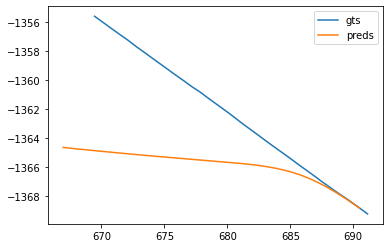

In [230]:
# print(indexes)
arr1 = np.array(position_gts_world)
arr2 = np.array(position_preds_world)
arr = arr1 - arr2
print(arr)
plt.plot(arr1[:, 0], arr1[:, 1], label = "gts")
plt.plot(arr2[:, 0], arr2[:, 1], label = "preds")
# axes = plt.gca()
# axes.set_xlim([680, 690])
# axes.set_ylim([-2200, -2170])
plt.legend()
plt.show()

In [21]:
# visualise the result
from IPython.display import display, clear_output
import PIL
 
for frame_number in range(50):
    
    data = eval_dataloader.dataset[frame_number]

    data_batch = default_collate([data])
    data_batch = {k: v.to(device) for k, v in data_batch.items()}
    
    result = model(data_batch)
    predicted_positions = result["positions"].detach().cpu().numpy().squeeze()

    
    predicted_positions = transform_points(predicted_positions, data["raster_from_agent"])
    target_positions = transform_points(data["target_positions"], data["raster_from_agent"])
    
    im_ego = rasterizer.to_rgb(data["image"].transpose(1, 2, 0))
    draw_trajectory(im_ego, target_positions, TARGET_POINTS_COLOR)
    draw_trajectory(im_ego, predicted_positions, PREDICTED_POINTS_COLOR)
    
    clear_output(wait=True)
    display(PIL.Image.fromarray(im_ego))

NameError: name 'device' is not defined

# Evaluation loop

Here, we loop through the data and store predicted and annotated trajectories (positions + yaws).

Note: we're not taking into account availability here. We acknowledge this can reflect in a lower score.

In [ ]:
# ==== EVAL LOOP
position_preds = []
yaw_preds = []

position_gts = []
yaw_gts = []

torch.set_grad_enabled(False)

for idx_data, data in enumerate(tqdm(eval_dataloader)):
    data = {k: v.to(device) for k, v in data.items()}
    result = model(data)
    position_preds.append(result["positions"].detach().cpu().numpy())
    yaw_preds.append (result["yaws"].detach().cpu().numpy())

    position_gts.append(data["target_positions"].detach().cpu().numpy())
    yaw_gts.append(data["target_yaws"].detach().cpu().numpy())
    if idx_data == 10:
        break
    
position_preds = np.concatenate(position_preds)
yaw_preds = np.concatenate(yaw_preds)

position_gts = np.concatenate(position_gts)
yaw_gts = np.concatenate(yaw_gts)

# Quantitative evaluation

## ADE, FDE and angle distance

### Positional displacement
[Average Displacement Error (ADE) and Final Displacement Error (FDE)](https://en.wikipedia.org/wiki/Mean_squared_displacement) are standard metrics used to evaluate future predictions for AVs.

We can compute them by comparing predicted and annotated positions, which we have stored in the previous cell.
Additionally, we can plot histograms of their distributions across samples to better capture the variance of our error.

### Angle displacement

For the yaw, we can use the Minimum Angle Distance to check the error. Again, we can plot a histogram to inspect the error distribution. 

Although yaw may seem redundant here, it's actually crucial to fully control the SDV. We'll use it extensively in the closed-loop evaluation notebook.

In [ ]:
pos_errors = np.linalg.norm(position_preds - position_gts, axis=-1)

# DISPLACEMENT AT T
plt.plot(np.arange(pos_errors.shape[1]), pos_errors.mean(0), label="Displacement error at T")
plt.legend()
plt.show()

# ADE HIST
plt.hist(pos_errors.mean(-1), bins=100, label="ADE Histogram")
plt.legend()
plt.show()

# FDE HIST
plt.hist(pos_errors[:,-1], bins=100, label="FDE Histogram")
plt.legend()
plt.show()

angle_errors = angular_distance(yaw_preds, yaw_gts).squeeze()

# ANGLE ERROR AT T
plt.plot(np.arange(angle_errors.shape[1]), angle_errors.mean(0), label="Angle error at T")
plt.legend()
plt.show()

# ANGLE ERROR HIST
plt.hist(angle_errors.mean(-1), bins=100, label="Angle Error Histogram")
plt.legend()
plt.show()

# Qualitative evaluation

## Visualise results
We can also visualise some images with predicted and annotated trajectories using L5Kit visualisation features.

In this example, we draw 20 images from our dataset and we visualise predicted and annotated trajectories on top of them.

In [ ]:
for frame_number in range(0, len(eval_dataset), len(eval_dataset) // 20):
    
    data = eval_dataloader.dataset[frame_number]
    data_batch = default_collate([data])
    data_batch = {k: v.to(device) for k, v in data_batch.items()}
    result = model(data_batch)
    predicted_positions = result["positions"].detach().cpu().numpy().squeeze()

    im_ego = rasterizer.to_rgb(data["image"].transpose(1, 2, 0))
    target_positions = data["target_positions"]
    
    predicted_positions = transform_points(predicted_positions, data["raster_from_agent"])
    target_positions = transform_points(target_positions, data["raster_from_agent"])
    
    draw_trajectory(im_ego, predicted_positions, PREDICTED_POINTS_COLOR)
    
    draw_trajectory(im_ego, target_positions, TARGET_POINTS_COLOR)

    plt.imshow(im_ego)
    plt.axis("off")
    plt.show()

## Visualise the open-loop

To visualise the open loop we can just repeat the same operations for the consecutive frames.

In this example, we show the first 200 frames for our dataset, plotting predicted and annotated trajectories.

**We want to stress this out again: this is an open loop evaluation, we are NOT controlling the AV with our predictions**

In [ ]:
from IPython.display import display, clear_output
import PIL
 
for frame_number in range(200):
    
    data = eval_dataloader.dataset[frame_number]

    data_batch = default_collate([data])
    data_batch = {k: v.to(device) for k, v in data_batch.items()}
    
    result = model(data_batch)
    predicted_positions = result["positions"].detach().cpu().numpy().squeeze()

    
    predicted_positions = transform_points(predicted_positions, data["raster_from_agent"])
    target_positions = transform_points(data["target_positions"], data["raster_from_agent"])
    
    im_ego = rasterizer.to_rgb(data["image"].transpose(1, 2, 0))
    draw_trajectory(im_ego, target_positions, TARGET_POINTS_COLOR)
    draw_trajectory(im_ego, predicted_positions, PREDICTED_POINTS_COLOR)
    
    clear_output(wait=True)
    display(PIL.Image.fromarray(im_ego))

# Pre-trained model results

We include here the open-loop results of one scene using one of our pre-trained model. The predicted trajectory is well overlapped with the annotated one.

![SegmentLocal](../../docs/images/planning/out_9_open.gif "segment")